UC Berkeley W207 - Machine Learning
Miki Seltzer, Eric Freeman, Christopher Llop

This Notebook contains our solution to the Kaggle SF Crime problem available at:
https://www.kaggle.com/c/sf-crime

The notebook covers the following methods and includes discussion of key decisions along the way (as of 2015-06-17). If you are not part of our W207 class, you are welcome to look through our methods and leverage our code to develop new solutions. We may also continue work after creating this report - just go by the "last modified" date on GitHub.

Concepts Covered:
1. Basic data exploration
2. K-Nearest Neighbors
3. Logistic Regression
4. Bernoulli Naive Bayes
5. Gradient Boosting
6. Neural Networks


In [10]:
#This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import csv
import datetime

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

# Libraries for Neural Networks. The versions currently available via "pip" are not up to date, and do
# not sync with each other. To use these packages, install directly from github using the instructions
# here:
# https://github.com/dnouri/nolearn
from lasagne import layers
from lasagne import nonlinearities
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet


#Data Explorations

We started with a basic exploration of the data. For the purposes of this report only some of those checks are
shown below. You can examine these searches further in the "Load and Examine Data" iPython notebook. 

Some tasks:    
- Count unique values for each variable
- View most common values
- XY plot of lat/long w. circles to indicate number of crimes
- Time series plots to see how category use changes over time

Interesting Points:
- Most crime on Friday, then Wednesday. Least on Sunday.
- X and Y latitude have same number of distinct values. Seem to be somehow linked to locations
  since, despite there being a lots of sig fig, they still can be frequency counted
- 800 Block of BRYANT ST has 4x+ more data points than anyplace else. Seems to link w/ most freq X and Y
- "Other Offenses" are common
- The dates with the most crime are new years day. Also the first of months.
- Note: Strange max value of Y = 90 for 67 values. These appear to be in Chicago, but the data has addresses in SF. We removed this data from our analysis.

In [25]:
data_orig = pd.read_csv("train.csv")
test_orig = pd.read_csv("test.csv")

# Count distinct for each variable:
print "There are a total of {:,}, values.".format(len(data_orig))

for var, series in data_orig.iteritems():
    print "There are a total of {:,} {}.".format(len(series.value_counts()), var)
# View All of Categories, PdDistrict, Resolution, DayOfWeek
variables = ["Category", "PdDistrict", "Resolution"]
x = data_orig["Category"].value_counts()/len(data_orig)
for col in variables:
    print "-------------------------------------------------------------------------"
    print "There are a total of {:,} distinct {} values, as follows: ".format(len(data_orig[col].value_counts()), col)
    print data_orig[col].value_counts()/len(data_orig)
    print

There are a total of 878,049, values.
There are a total of 389,257 Dates.
There are a total of 39 Category.
There are a total of 879 Descript.
There are a total of 7 DayOfWeek.
There are a total of 10 PdDistrict.
There are a total of 17 Resolution.
There are a total of 23,228 Address.
There are a total of 34,243 X.
There are a total of 34,243 Y.
-------------------------------------------------------------------------
There are a total of 39 distinct Category values, as follows: 
LARCENY/THEFT                  0.199192
OTHER OFFENSES                 0.143707
NON-CRIMINAL                   0.105124
ASSAULT                        0.087553
DRUG/NARCOTIC                  0.061467
VEHICLE THEFT                  0.061251
VANDALISM                      0.050937
WARRANTS                       0.048077
BURGLARY                       0.041860
SUSPICIOUS OCC                 0.035777
MISSING PERSON                 0.029599
ROBBERY                        0.026194
FRAUD                          0.01

We added several new date related features to the dataset right away, which were used in data investigations.

In [4]:
data_clean = data_orig[data_orig.Y != 90]

def add_date_vars(data):
    data['Dates'] = pd.to_datetime(data['Dates'])
    data['Year'] = data.Dates.dt.year
    data['Month'] = data.Dates.dt.month
    data['Day'] = data.Dates.dt.day
    data['Date'] = data.Dates.dt.date
    data['Hour'] = data.Dates.dt.hour
    data['DayOfYear'] = data.Dates.dt.dayofyear
    data['WeekDay'] = data.Dates.dt.weekday
    
    datetime_vector = data['Dates']
    date_vector = datetime_vector.dt.date
    date_diff_vector = (date_vector - date_vector.min()) / np.timedelta64(1, 'D')
    data['DateDiff'] = date_diff_vector


add_date_vars(data_clean)
add_date_vars(test_orig)

We also created a standard "output" function that we used across sensitivites

In [5]:
# Create a function that will create a correctly formatted output file for submission to Kaggle.

def create_submission(preds):
    labels = ["Id","ARSON","ASSAULT","BAD CHECKS","BRIBERY","BURGLARY","DISORDERLY CONDUCT","DRIVING UNDER THE INFLUENCE",
              "DRUG/NARCOTIC","DRUNKENNESS","EMBEZZLEMENT","EXTORTION","FAMILY OFFENSES","FORGERY/COUNTERFEITING",
              "FRAUD","GAMBLING","KIDNAPPING","LARCENY/THEFT","LIQUOR LAWS","LOITERING","MISSING PERSON","NON-CRIMINAL",
              "OTHER OFFENSES","PORNOGRAPHY/OBSCENE MAT","PROSTITUTION","RECOVERED VEHICLE","ROBBERY","RUNAWAY",
              "SECONDARY CODES","SEX OFFENSES FORCIBLE","SEX OFFENSES NON FORCIBLE","STOLEN PROPERTY","SUICIDE",
              "SUSPICIOUS OCC","TREA","TRESPASS","VANDALISM","VEHICLE THEFT","WARRANTS","WEAPON LAWS"]
    head_str = ','.join(labels)

    num_cats = len(labels)
    
    # Make a dummy row to append to
    ids = np.arange(preds.shape[0])[np.newaxis].transpose()
    
    results = np.column_stack((ids, preds))

    num_form = ['%6f'] * (num_cats - 1)
    num_form.insert(0, '%d')
    # Write results to csv
    np.savetxt('sample.csv', results, fmt=num_form, delimiter=',', header=head_str, comments='')


#K-Nearest Neighbors

Our first model was a simple KNN model. We tried a variety of N's for neighbors and both normalized and regular data. We also looked at just including a subset of crimes for it to predict. We first submitted a model using N=1, normalized data, and only attempted to predict the top 4 crimes. 

KNN makes classification predictions based on the nearest neighbors - the predicted category is set to 1 and all others to 0. This resulted in a low score (27) because the ranking algorithm expected us to submit the likelihood of each potential classification, instead of just an absolute guess.

For the final KNN submission, we replaced the 0's with average probability of the crime as observed in the entire dataset. This simple change improved submission score from 27 to 2.92.

We then tried to optimize N, and found that N = 1000 made an improvement to accuracy, but only by about 2%.

In [6]:
# Only look at top 4 crimes
stk_list = ['LARCENY/THEFT','OTHER OFFENSES','NON-CRIMINAL','ASSAULT']
data = data_clean[data_clean.Category.isin(stk_list)]

# Create random dev sample so we can see how that accuracy compares to our Kaggle results
np.random.seed(100)

rows = np.random.choice(data.index, size = len(data) / 10, replace = False)

dev = data.ix[rows]
train = data.drop(rows)

# Convert to Numpy Format with only DateDiff, X and Y features
train_data = np.array(train[['DateDiff','X','Y']].values)
train_labels = np.array(train[['Category']].values.ravel())

dev_data = np.array(dev[['DateDiff','X','Y']].values)
dev_labels = np.array(dev[['Category']].values.ravel())

full_data = np.array(data[['DateDiff','X','Y']].values)
full_labels = np.array(data[['Category']].values.ravel())

test_data = np.array(test_orig[['DateDiff','X','Y']].values)

# Normalize Data to Between 0-1
#a + (x-A)*(b-a)/(B-A) 

def normalize(data):
    return 0 + (np.abs(data) - np.abs(data).min(axis=0))*(1-0)/(np.abs(data).max(axis=0) - np.abs(data).min(axis=0))

train_normed = normalize(train_data)
dev_normed = normalize(dev_data)
test_normed = normalize(test_data)
full_normed = normalize(full_data)

In [7]:
# Use GridSearchCV to find a good number of neighbors.

# ks = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
ks = {'n_neighbors': [1, 5, 10, 100, 1000]}
KNNGridSearch = GridSearchCV(KNeighborsClassifier(), ks, scoring='accuracy')
KNNGridSearch.fit(train_normed, train_labels)

# Report out on the accuracies    
print "The scores for each N value was %s " % (KNNGridSearch.grid_scores_)
print "\nThe best N value was %s with accuracy %.4f" % (KNNGridSearch.best_params_, KNNGridSearch.best_score_)
best_n = KNNGridSearch.best_params_['n_neighbors']

The scores for each k value was [mean: 0.22013, std: 0.03731, params: {'n_neighbors': 1}, mean: 0.22913, std: 0.04194, params: {'n_neighbors': 5}, mean: 0.23831, std: 0.04801, params: {'n_neighbors': 10}, mean: 0.26714, std: 0.06603, params: {'n_neighbors': 100}, mean: 0.30380, std: 0.05516, params: {'n_neighbors': 1000}] 

The best k value was {'n_neighbors': 1000} with accuracy 0.3038


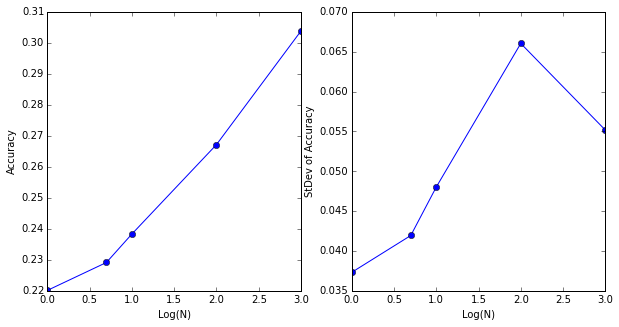

K-Nearest Neighbors

model           neighbors accuracy  
-----------------------------------
baseline        5         0.4179    
optimized n     1000      0.4397    


In [8]:
res = zip(*[(f1m, f1s.std(), p['n_neighbors']) 
            for p, f1m, f1s in KNNGridSearch.grid_scores_])

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(np.log10(res[2]),res[0],'-o')
plt.xlabel("Log(N)")
plt.ylabel("Accuracy")
plt.subplot(1,2,2)
plt.plot(np.log10(res[2]),res[1],'-o')
plt.xlabel("Log(N)")
plt.ylabel("StDev of Accuracy")
plt.show()

result_form = "{:<16s}{:<10d}{:<10.4f}".format
print "K-Nearest Neighbors\n"
print "{:<16s}{:<10s}{:<10s}".format("model", "neighbors", "accuracy")
print "-----------------------------------"

# Now that we've done this, let's run the KNN on the full train, apply to the test, then format.
KNNmodel = KNeighborsClassifier()
KNNmodel.fit(train_normed, train_labels)
base_n = 5
base_accuracy = KNNmodel.score(dev_normed, dev_labels)
print result_form("baseline", base_n, base_accuracy)

# Use optimized N
KNNmodel = KNeighborsClassifier(n_neighbors = best_n)
KNNmodel.fit(train_normed, train_labels)
accuracy = KNNmodel.score(dev_normed, dev_labels)
print result_form("optimized n", best_n, accuracy)
# test_predict = KNNmodel.predict_proba(test_normed).astype(int)

We should note that entering the other 35 categories with their average probability was done by hand in Excel. We looked at doing it in python, but realized we wanted to pursue other models instead. The create_submission function needs all categories to be input, so in this case we did not use the create_submission function. 

#Logistic Regression

The second model was logistic regression. A logistic regression method (and all others examined in this notebook) allows output of predicted probabilites, removing the need to use the simple occurance averages.

We tried several values of C, which determines the regularization strength, before settling on C=0.001. This improved our score from 2.92 to 2.69.

After submitting this model, we tried averaging the KNN and LR in various ways, but that did not improve the performance.

In [75]:
# Let's go back to using all crimes
data = data_clean.copy()

np.random.seed()
rows = np.random.choice(data.index, size = len(data) / 10, replace = False)

dev = data.ix[rows]
train = data.drop(rows)

# Convert to Numpy Format with only DateDiff, X and Y features
train_data = np.array(train[['DateDiff','X','Y']].values)
train_labels = np.array(train[['Category']].values.ravel())

dev_data = np.array(dev[['DateDiff','X','Y']].values)
dev_labels = np.array(dev[['Category']].values.ravel())

full_data = np.array(data[['DateDiff','X','Y']].values)
full_labels = np.array(data[['Category']].values.ravel())

test_data = np.array(test_orig[['DateDiff','X','Y']].values)

# We need to re-normalize the data sets containing all crimes, not just the top 4 crimes
train_normed = normalize(train_data)
dev_normed = normalize(dev_data)
test_normed = normalize(test_data)
full_normed = normalize(full_data)

print len(dev['Category'].unique())
print len(train['Category'].unique())

39
39


In [77]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
clf.fit(train_data, train_labels)
print clf.best_params_
best_c = clf.best_params_['C']

{'C': 0.001}


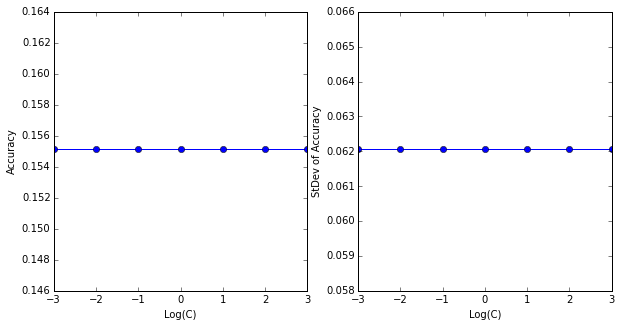

Logistic Regression

model           C         accuracy  log-loss  
---------------------------------------------
baseline        1.0000    0.2156    2.6448    
optimized C     0.0010    0.2148    2.6977    


In [78]:
res = zip(*[(f1m, f1s.std(), p['C']) 
            for p, f1m, f1s in clf.grid_scores_])

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(np.log10(res[2]),res[0],'-o')
plt.xlabel("Log(C)")
plt.ylabel("Accuracy")
plt.subplot(1,2,2)
plt.plot(np.log10(res[2]),res[1],'-o')
plt.xlabel("Log(C)")
plt.ylabel("StDev of Accuracy")
plt.show()

result_form = "{:<16s}{:<10.4f}{:<10.4f}{:<10.4f}".format
print "Logistic Regression\n"
print "{:<16s}{:<10s}{:<10s}{:<10s}".format("model", "C", "accuracy", "log-loss")
print "---------------------------------------------"

# Logistic Regression: baseline
model = LogisticRegression()
model.fit(train_normed, train_labels)
base_c = 1.0
base_accuracy = model.score(dev_normed, dev_labels)
base_logloss = log_loss(dev_labels, model.predict_proba(dev_normed)) 
print result_form("baseline", base_c, base_accuracy, base_logloss)

# Logistic Regression: optimized C
model.set_params(C=best_c)
model.fit(train_normed, train_labels)
test_predict = model.predict_proba(test_normed)
accuracy = model.score(dev_normed, dev_labels)
logloss = log_loss(dev_labels, model.predict_proba(dev_normed)) 
print result_form("optimized C", best_c, accuracy, logloss)

#results = create_submission(test_predict)

#Bernoulli Naive Bayes
##Feature Generation

BernoulliNB requires binary data, so we created dummy variables for each variable in the data set (all date and district variables). We also left all variables in the data set so that we could include and exclude features in our models easily.

In [12]:
# Extract new features in Pandas
def time_features(data):
    data['DateTime'] = pd.to_datetime(data['Dates'])
    data['Year'] = pd.DatetimeIndex(data['DateTime']).year
    data['Month'] = pd.DatetimeIndex(data['DateTime']).month
    data['Day'] = pd.DatetimeIndex(data['DateTime']).day
    data['Hour'] = pd.DatetimeIndex(data['DateTime']).hour
    data['SecondsDelta'] = (data.DateTime - pd.Timestamp('2013-01-01')) / np.timedelta64(1,'s')
    data['Weekend'] = (data.DayOfWeek == "Saturday") | (data.DayOfWeek == "Sunday")
    years = pd.get_dummies(data.Year)
    months = pd.get_dummies(data.Month)
    months.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    days = pd.get_dummies(data.Day)
    daysofweek = pd.get_dummies(data.DayOfWeek)
    hours = pd.get_dummies(data.Hour)
    hours.columns = ['12AM', '1AM', '2AM', '3AM', '4AM', '5AM',
                     '6AM', '7AM', '8AM', '9AM', '10AM', '11AM',
                     '12PM', '1PM', '2PM', '3PM', '4PM', '5PM',
                     '6PM', '7PM', '8PM', '9PM', '10PM', '11PM']
    districts = pd.get_dummies(data.PdDistrict)
    new_data = pd.concat([data, years, months, days, daysofweek, hours, districts], axis=1)
    return new_data

data = time_features(data_orig)
test = time_features(test_orig)

# Separate labels
labels = data.Category

# Drop Category, Descript and Resolution columns since we cannot use them to predict
train_data = data.drop(['Category', 'Descript', 'Resolution'], axis=1)
train_names = train_data.columns.values.tolist()
test_names = test.columns.values.tolist()

print data.columns.values

['Dates' 'Category' 'Descript' 'DayOfWeek' 'PdDistrict' 'Resolution'
 'Address' 'X' 'Y' 'DateTime' 'Year' 'Month' 'Day' 'Hour' 'SecondsDelta'
 'Weekend' 2003L 2004L 2005L 2006L 2007L 2008L 2009L 2010L 2011L 2012L
 2013L 2014L 2015L 'Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sep'
 'Oct' 'Nov' 'Dec' 1L 2L 3L 4L 5L 6L 7L 8L 9L 10L 11L 12L 13L 14L 15L 16L
 17L 18L 19L 20L 21L 22L 23L 24L 25L 26L 27L 28L 29L 30L 31L 'Friday'
 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday' '12AM' '1AM'
 '2AM' '3AM' '4AM' '5AM' '6AM' '7AM' '8AM' '9AM' '10AM' '11AM' '12PM' '1PM'
 '2PM' '3PM' '4PM' '5PM' '6PM' '7PM' '8PM' '9PM' '10PM' '11PM' 'BAYVIEW'
 'CENTRAL' 'INGLESIDE' 'MISSION' 'NORTHERN' 'PARK' 'RICHMOND' 'SOUTHERN'
 'TARAVAL' 'TENDERLOIN']


In [13]:
# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to features.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.

shuffle = np.random.permutation(np.arange(train_data.shape[0]))
train_data = train_data.reindex(shuffle)
labels = labels.reindex(shuffle)

# Remove records where Y == 90
train_data_clean = train_data[train_data.Y != 90]
labels_clean = labels[train_data.Y != 90]
num_examples = train_data_clean.shape[0]

# Split the feature and label sets into train and dev sets
mini_train_data = train_data_clean[:10000]
mini_train_labels = labels_clean[:10000]

reg_train_data = train_data_clean[10000:num_examples/2]
reg_train_labels = labels_clean[10000:num_examples/2]

dev_data = train_data_clean[num_examples/2:]
dev_labels = labels_clean[num_examples/2:]

test_data = test.copy()

print "Mini Train Data:", mini_train_data.shape
print "Mini Train Labels:", mini_train_labels.shape
print "Mini Train Unique Labels:", len(mini_train_labels.unique())
print "\nRegular Train Data:", reg_train_data.shape
print "Regular Train Labels:", reg_train_labels.shape
print "Regular Train Unique Labels:", len(reg_train_labels.unique())
print "\nDev Data:", dev_data.shape
print "Dev Labels:", dev_labels.shape
print "Dev Train Unique Labels:", len(dev_labels.unique())
print "\nTest Data:", test_data.shape
print "\nColumns in use:", train_names

Mini Train Data: (10000, 110)
Mini Train Labels: (10000L,)
Mini Train Unique Labels: 38

Regular Train Data: (428991, 110)
Regular Train Labels: (428991L,)
Regular Train Unique Labels: 39

Dev Data: (438991, 110)
Dev Labels: (438991L,)
Dev Train Unique Labels: 39

Test Data: (884262, 111)

Columns in use: ['Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y', 'DateTime', 'Year', 'Month', 'Day', 'Hour', 'SecondsDelta', 'Weekend', 2003L, 2004L, 2005L, 2006L, 2007L, 2008L, 2009L, 2010L, 2011L, 2012L, 2013L, 2014L, 2015L, 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 1L, 2L, 3L, 4L, 5L, 6L, 7L, 8L, 9L, 10L, 11L, 12L, 13L, 14L, 15L, 16L, 17L, 18L, 19L, 20L, 21L, 22L, 23L, 24L, 25L, 26L, 27L, 28L, 29L, 30L, 31L, 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM',

Note: Some of the category labels have very few examples. When randomizing we need to make sure that dev and regular train data both contain 39 unique category labels.

In [14]:
features_to_use = [2003L, 2004L, 2005L, 2006L, 2007L, 2008L, 2009L, 2010L, 2011L, 2012L, 2013L, 2014L, 2015L, 
                   'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
                   1L, 2L, 3L, 4L, 5L, 6L, 7L, 8L, 9L, 10L, 11L, 12L, 13L, 14L, 15L, 
                   16L, 17L, 18L, 19L, 20L, 21L, 22L, 23L, 24L, 25L, 26L, 27L, 28L, 29L, 30L, 31L, 
                   'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 
                   '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', 
                   '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 
                   'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 
                   'SOUTHERN', 'TARAVAL', 'TENDERLOIN', 'X', 'Y'
                   ]

print "Number of features:", len(features_to_use)

Number of features: 99


##Bernoulli NB Model Creation

The third model used Bernoulli Naive Bayes, which scored about the same as logistic regression.

We tried using several variations of the Bernoulli NB model. After optimizing alpha, we tried bagging to determine if we could get a more robust model. We also tried using PCA to reduce dimensions and using those new features in the Bernoulli NB model. However, neither of these made any improvements to the original Bernoulli NB model!

Best parameter:
{'alpha': 1.0}

Best score:
2.56622149659


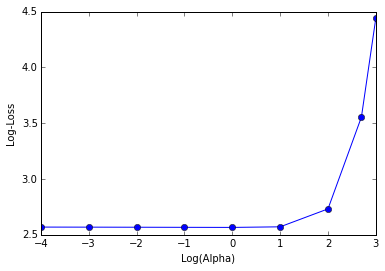

In [21]:
# Let's see what the optimal alpha is for a Bernoulli NB model

params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 500.0, 1000.0]}

clf = GridSearchCV(BernoulliNB(), [params], scoring='log_loss')
clf.fit(reg_train_data[features_to_use], reg_train_labels)

print "Best parameter:\n", clf.best_params_
print "\nBest score:\n", -1 * clf.best_score_

best_alpha = clf.best_params_['alpha']

scores = [clf.grid_scores_[i][1] * -1 for i in range(len(clf.grid_scores_))]

plt.plot(np.log10(params['alpha']), scores, marker='o')
plt.xlabel("Log(Alpha)")
plt.ylabel("Log-Loss")
plt.show()

When we throw in 99 features (basically every feature we created), the log-loss is optimized when alpha = 1. However, the practical difference in log-loss up to alpha = 1 is very small. With alpha > 10, log-loss increases sharply.

In [41]:
print "Bernoulli NB\n"
print "{:<16s}{:<10s}{:<10s}{:<10s}".format("model", "alpha", "accuracy", "log-loss")
print "---------------------------------------------"

# Baseline Bernoulli NB model
bnb = BernoulliNB()
bnb.fit(reg_train_data[features_to_use], reg_train_labels)
base_alpha = 1.0
base_accuracy = bnb.score(dev_data[features_to_use], dev_labels)
base_logloss = log_loss(dev_labels, bnb.predict_proba(dev_data[features_to_use])) 
print result_form("baseline", base_alpha, base_accuracy, base_logloss)

# How well does the Bernoulli NB model do with the selected alpha?
bnb.set_params(alpha=best_alpha)
bnb.fit(reg_train_data[features_to_use], reg_train_labels)
bnb_probs = bnb.predict_proba(test_data[features_to_use])
accuracy = bnb.score(dev_data[features_to_use], dev_labels)
logloss = log_loss(dev_labels, bnb.predict_proba(dev_data[features_to_use]))
print result_form("optimized alpha", best_alpha, accuracy, logloss)

# Maybe bagging the Bernoulli NB model does us some good
bnb_bag = BaggingClassifier(BernoulliNB(alpha=best_alpha), max_features=0.8, max_samples = 0.8)
bnb_bag.fit(reg_train_data[features_to_use], reg_train_labels)
bnb_bag_probs = bnb_bag.predict_proba(test_data[features_to_use])
accuracy = bnb_bag.score(dev_data[features_to_use], dev_labels)
logloss = log_loss(dev_labels, bnb_bag.predict_proba(dev_data[features_to_use])) 
print result_form("bagged", best_alpha, accuracy, logloss)

# Perhaps doing some dimensionality reduction will help us
pca = PCA(n_components = 70)
pca_train_data = pca.fit_transform(reg_train_data[features_to_use])
pca_dev_data = pca.transform(dev_data[features_to_use])
pca_test_data = pca.transform(test_data[features_to_use])

bnb2 = BernoulliNB(best_alpha)
bnb2.fit(pca_train_data, reg_train_labels)
bnb2_probs = bnb2.predict_proba(pca_test_data)
accuracy = bnb2.score(pca_dev_data, dev_labels)
logloss = log_loss(dev_labels, bnb2.predict_proba(pca_dev_data)) 
print result_form("pca (70 comp)", best_alpha, accuracy, logloss)

Bernoulli NB

model           alpha     accuracy  log-loss  
---------------------------------------------
baseline        1.0000    0.2277    2.5656    
optimized alpha 1.0000    0.2277    2.5656    
bagged          1.0000    0.2258    2.5674    
pca (70 comp)   1.0000    0.1920    2.7547    


In [104]:
# Let's go back to the baseline model and see what errors we are making

bnb = BernoulliNB()
bnb.fit(reg_train_data[features_to_use], reg_train_labels)
predicted = bnb.predict(dev_data[features_to_use])

confusion = confusion_matrix(dev_labels, predicted)
np.set_printoptions(threshold='nan')

classes = reg_train_labels.unique()
classes.sort()

row_form = "      {:28s}{:>7d}{:>9.4f}".format
index = 0

print "{:<28s}{:>9s}{:>11s}{:>9s}".format("Correct class", "actual", "predicted", "correct")
for row in confusion:
    count = dev_labels.value_counts()[classes[index]]
    print "{:<28s}{:>9d}{:>11d}{:>9d}".format(classes[index], 
                                              count, 
                                              sum(predicted == classes[index]),
                                              confusion[index,index])
    index += 1

print "Confusion Matrix"
print confusion, "\n"

Correct class                  actual  predicted  correct
ARSON                             732          0        0
ASSAULT                         38487       7496     1281
BAD CHECKS                        213          0        0
BRIBERY                           145          0        0
BURGLARY                        18563        251       41
DISORDERLY CONDUCT               2152          0        0
DRIVING UNDER THE INFLUENCE      1142          0        0
DRUG/NARCOTIC                   26983      34607     8227
DRUNKENNESS                      2161          0        0
EMBEZZLEMENT                      577          0        0
EXTORTION                         121          0        0
FAMILY OFFENSES                   247          0        0
FORGERY/COUNTERFEITING           5324         80       12
FRAUD                            8406          0        0
GAMBLING                           58          0        0
KIDNAPPING                       1152          0        0
LARCENY/THEFT 

We can see from the table above that the Naive Bayes model is mostly predicting "LARCENY/THEFT" or "OTHER OFFENSES". Because the distribution of crimes is very skewed, the model seems to most frequently choose the class where there are a plethora of examples. There are a large number of crimes that the model never predicts, particularly the ones where there are not very many examples.

It is suprising that the model does not frequently predict "NON-CRIMINAL" crimes, even though there are many examples of these crimes.

#Gradient Boosting

We then tried gradient boosting, which improved our score to 2.49. Given the computational intensity of gradient boosting (initial model took 6 hours to run), we were unable to do significant parameter optimization. Increasing the leraning parameter to 0.2 seemed to improve the accuracy slightly, even with only 30 estimators. However, when the learning rate was increased further to 0.5, the accuracy decreased significantly.

In [60]:
print "Gradient Boosting\n"
print "{:<16s}{:<10s}{:<10s}{:<10s}".format("model", "param", "accuracy", "log-loss")
print "---------------------------------------------"

# Try Gradient Boosting
grad_boost = GradientBoostingClassifier()
grad_boost.fit(reg_train_data[features_to_use], reg_train_labels)
accuracy = grad_boost.score(dev_data[features_to_use], dev_labels)
logloss = log_loss(dev_labels, grad_boost.predict_proba(dev_data[features_to_use])) 
print "{:<16s}{:<10s}{:<10.4f}{:<10.4f}".format("baseline", "", accuracy, logloss)

Gradient Boosting

model           param     accuracy  log-loss  
---------------------------------------------
baseline                  0.2547    2.5018    


In [47]:
print "Gradient Boosting\n"
print "{:<16s}{:<10s}{:<10s}{:<10s}".format("iteration", "param", "accuracy", "log-loss")
print "---------------------------------------------"

# Let's try tweaking some parameters on the smaller data set
grad_boost = GradientBoostingClassifier(n_estimators = 30, learning_rate = 0.2)
grad_boost.fit(reg_train_data[features_to_use], reg_train_labels)
new_grad_boost_probs = grad_boost.predict_proba(test_data[features_to_use])
create_submission(new_grad_boost_probs)
new_accuracy = grad_boost.score(dev_data[features_to_use], dev_labels)
# new_logloss = log_loss(dev_labels, grad_boost.predict_proba(dev_data[features_to_use])) 
print "{:<16s}{:<10s}{:<10s}{:<10s}".format("n_estimators", "30", "", "")
print "{:<16s}{:<10s}{:<10.4f}{:<10.4f}".format("learning_rate", "0.2", new_accuracy, new_logloss)
print "---------------------------------------------"

# Let's try increasing the learning rate again
grad_boost2 = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.5)
grad_boost2.fit(reg_train_data[features_to_use], reg_train_labels)
new_accuracy2 = grad_boost2.score(dev_data[features_to_use], dev_labels)
new_logloss2 = log_loss(dev_labels, grad_boost2.predict_proba(dev_data[features_to_use])) 
print "{:<16s}{:<10s}{:<10s}{:<10s}".format("n_estimators", "100", "", "")
print "{:<16s}{:<10s}{:<10.4f}{:<10.4f}".format("learning_rate", "0.5", new_accuracy2, new_logloss2)

Gradient Boosting

iteration       param     accuracy  log-loss  
---------------------------------------------
n_estimators    30                            
learning_rate   0.2       0.2537    2.4943    
---------------------------------------------
n_estimators    100                           
learning_rate   0.5       0.0478    32.8866   


#Neural Networks

Finally, we used a neural net, which got our best score of 2.43. This was enough to enter the top 50 in the SF Learns competition (as of August 17th).

We ran the Neural Network using a combination of NoLearn, Lasange, and Theano. NoLearn and Lasange are both under development, so to replicate this code please follow the installation instructions on NoLearn, below. NoLearn is built on top of Lasange and Theano, and thus its requirements are the ones to follow
https://github.com/dnouri/nolearn




We tried two differnet types of Neural Networks - a 1-hidden layer network, then a 2-hidden layer network with a dropout layer between. The 2-hidden layer network resulted in only minor improvements. While the NoLearn/Lasange/Theano pipeline allows Neural Nets to be trained on certain types of GPU, we were not using such a machine for our development. As such, each model run took roughly an hour and limited the amount of runs possible.

## Neural Net Feature Generation

We tried many different features in the Neural Net model. Interestingly enough, the "year" and "month" dummy variables caused the model to diverge, leading to poor prediction. These were dropped from the final model in place of a few simple booleans flagging if a crime occured before 2008, before 2010, and before 2012.

We also parsed the X-Y coorinates into a series of dummy variables by rounding each coordinate to the 3rd decimal place. An attempt was made to round to the 4th decimal place and generate more features, however the computers available to us were unable to do this task. If work continues, this could be attempted via the cloud such as on AWS.

Note that NoLearn automatically splits the data into training and development sets (default of 80/20 split) each iteration, so we did not need to clean a development set for this run.

In [3]:
# Generate location-based dummies
XR3 = data['X'].round(decimals=3).apply(str)
YR3 = data['Y'].round(decimals=3).apply(str)
data_XR3s = pd.get_dummies(XR3)
data_YR3s = pd.get_dummies(YR3)    
XR3 = test['X'].round(decimals=3).apply(str)
YR3 = test['Y'].round(decimals=3).apply(str)
test_XR3s = pd.get_dummies(XR3)
test_YR3s = pd.get_dummies(YR3)    

#Subset the test to only include features that exist in training set
test_XR3s = test_XR3s[list(data_XR3s)]
test_YR3s = test_YR3s[list(data_YR3s)]

print data_XR3s.shape
print data_YR3s.shape
print
print test_XR3s.shape
print test_YR3s.shape



(878049, 147)
(878049, 107)

(884262, 147)
(884262, 107)


In [4]:
# Separate labels
train_labels = data.Category

# Create integer labels
panda_labels = pd.Categorical(data.Category).codes
train_labels_int = np.array(panda_labels).astype(np.int32)

# Drop Category, Descript and Resolution columns since they are not in the test set.
# Drop non-numerics too - they are accounted for as dummy variables.
train_data = data.drop(['Category', 'Descript', 'Resolution', 'DateTime', 'Dates', 'PdDistrict', 'Address', 'DayOfWeek'], axis=1)
train_data.Weekend = train_data.Weekend * 1
train_names = train_data.columns.values.tolist()

test_data = test.drop(['DateTime', 'Dates', 'PdDistrict', 'Address', 'DayOfWeek'], axis=1)
test_data.Weekend = test_data.Weekend * 1
test_names = test_data.columns.values.tolist()


We attempted many different combinations of features. Some worked better than others, and a few unexpectedly diverged. The features below were used in our final set

In [5]:
features = ['Jan','Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN']
np_train_data = np.array(pd.concat([train_data[features], (data.Year < 2006) * 1, (data.Year < 2008) * 1, (data.Year < 2010) * 1, data_XR3s, data_YR3s], axis=1))
np_test_data = np.array(pd.concat([test_data[features], (test.Year < 2006) * 1, (test.Year < 2008) * 1, (test.Year < 2010) * 1, test_XR3s[list(data_XR3s)], test_YR3s[list(data_YR3s)]], axis=1))


## Neural Net with 1 Hidden Layer

NoLearn/Lasagne makes it easy to define a net in terms of layers. We tried a number of hidden units and learning rates before settling on these parameters. We stopped after 65 iterations (epochs) through network updating because we observed overfitting around this point (that is, our accuracy on the training dataset continued to improve but accuracy on the development dataset began to fall).

In [6]:
# The accuracy was 0.293386815542 (train + dev) before stopping potential overfitting
# However, we stopped early @ 65 epochs to prevent overfitting
num_features = np_train_data.shape[1]

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, num_features),  # automatically calculate the number of featrues
    hidden_num_units=500,  # number of units in hidden layer
    output_nonlinearity=nonlinearities.softmax,
    output_num_units=39,  # 39 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.002,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=65,  # we want to train this many epochs
    verbose=1,
    )

print np_train_data.shape
print train_labels.shape
net1.fit(np_train_data, train_labels_int)

(878049, 299)
(878049,)
# Neural Network with 169539 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input      299
  1  hidden     500
  2  output      39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.63157       2.63910      0.99715      0.22339  29.22s
      2       2.52321       2.60649      0.96805      0.22637  29.03s
      3       2.49771       2.58853      0.96492      0.22857  29.44s
      4       2.48268       2.57886      0.96270      0.23122  29.51s
      5       2.47280       2.57330      0.96095      0.23314  29.57s
      6       2.46526       2.56965      0.95938      0.23488  29.32s
      7       2.45889       2.56691      0.95792      0.23767  28.03s
      8       2.45323       2.56476      0.95651      0.23948  27.25s
      9       2.44806       2.56277      0.95524      0.24086  27.55s
     10       2.44328       2.56095

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c8b9a10>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c8b9990>,
     custom_score=None, hidden_num_units=500, input_shape=(None, 299),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=65, more_params={},
     objective=<function objective at 0x10c8c4140>,
     objective_loss_function=<function categorical_crossentropy at 0x10c6b4140>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x10448b758>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x1148486c8>],
     output_nonlinearity=<function softmax at 0x10c5607d0>,
     output_num_units=39, regression=False,
     train_split=<nolearn.lasagne.base.TrainSplit object

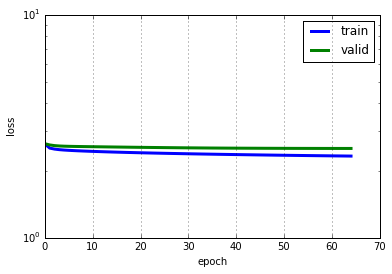

In [7]:
train_loss = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-0, 1e1)
plt.yscale("log")
plt.show()


In [11]:
# View accuracy for each classification type. Note that this accuracy is measured on all training data, and thus
# is higher than what we would expect on test data. This metric still was useful when comparing feature sets and model
# hyperparamaters.

train_pred = net1.predict(np_train_data)
print(classification_report(train_labels_int, train_pred))
print 'The accuracy is:', accuracy_score(train_labels_int, train_pred)

# Get probabilities for submission to Kaggle
test_proba = net1.predict_proba(np_test_data)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1513
          1       0.20      0.14      0.16     76876
          2       0.00      0.00      0.00       406
          3       0.00      0.00      0.00       289
          4       0.22      0.02      0.04     36755
          5       0.21      0.00      0.01      4320
          6       0.00      0.00      0.00      2268
          7       0.29      0.50      0.37     53971
          8       0.00      0.00      0.00      4280
          9       0.00      0.00      0.00      1166
         10       0.00      0.00      0.00       256
         11       0.00      0.00      0.00       491
         12       0.19      0.01      0.01     10609
         13       0.25      0.00      0.00     16679
         14       0.00      0.00      0.00       146
         15       0.00      0.00      0.00      2341
         16       0.32      0.72      0.45    174900
         17       0.00      0.00      0.00   

##Neural Net with 2 Hidden Layers + 1 Dropout Layer

We next tried adding an additional hidden layer, including a "dropout layer" to help prevent overfitting. The dropout layer randomly severs a certain percentage of the connections between the nodes.

We iterated through many possible values and settled on the ones below. However, further iteration with a faster processing speed (via a GPU) would likely lead to improvements.

In [12]:
num_features = np_train_data.shape[1]

net2 = NeuralNet(
    layers=[  # more layers
        ('input', layers.InputLayer),
        ('dense0', layers.DenseLayer),
        ('dropout', layers.DropoutLayer),
        ('dense1', layers.DenseLayer),
        ('output', layers.DenseLayer)
    ],
    # layer parameters:
    input_shape=(None, num_features),  # 3 input pixels per batch
    dense0_num_units=500,  # number of units in hidden layer
    dropout_p=0.5,  # randomly disconect a number of notes to help preven overfitting
    dense1_num_units=500,  # number of units in hidden layer
    output_num_units=39,  # 39 target values
    output_nonlinearity=nonlinearities.softmax,

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.02,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=40,  # we want to train this many epochs
    verbose=1,
    )

net2.fit(np_train_data, train_labels_int)


# Neural Network with 420039 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input       299
  1  dense0      500
  2  dropout     500
  3  dense1      500
  4  output       39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.49777       2.64343      0.94490      0.22286  80.71s
      2       2.43491       2.59972      0.93660      0.23403  80.35s
      3       2.41387       2.57477      0.93751      0.24013  81.41s
      4       2.40082       2.55420      0.93995      0.24428  82.20s
      5       2.39132       2.54141      0.94094      0.24588  83.52s
      6       2.38321       2.53455      0.94029      0.24774  82.93s
      7       2.37690       2.52936      0.93972      0.24789  82.61s
      8       2.37140       2.51653      0.94233      0.25034  82.85s
      9       2.36682       2.51053      0.94276      0.25273  82.66s
     10     

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c8b9a10>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c8b9990>,
     custom_score=None, dense0_num_units=500, dense1_num_units=500,
     dropout_p=0.5, input_shape=(None, 299),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('dense0', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout', <class 'lasagne.layers.noise.DropoutLayer'>), ('dense1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=40, more_params={},
     objective=<function objective at 0x10c8c4140>,
     objective_loss_function=<function categorical_crossentropy at 0x10c6b4140>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x114d990e0>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x114d99320>],
     

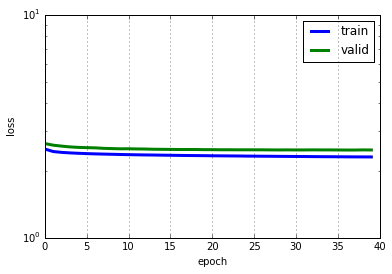

In [13]:
train_loss = np.array([i["train_loss"] for i in net2.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net2.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-0, 1e1)
plt.yscale("log")
plt.show()


In [17]:
train_pred = net2.predict(np_train_data)
print(classification_report(train_labels_int, train_pred))
print 'The accuracy is:', accuracy_score(train_labels_int, train_pred)

# Get probabilities for submission to Kaggle
test_proba = net2.predict_proba(np_test_data)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1513
          1       0.20      0.20      0.20     76876
          2       0.00      0.00      0.00       406
          3       0.00      0.00      0.00       289
          4       0.24      0.06      0.09     36755
          5       0.29      0.04      0.06      4320
          6       0.00      0.00      0.00      2268
          7       0.31      0.48      0.38     53971
          8       0.00      0.00      0.00      4280
          9       0.00      0.00      0.00      1166
         10       0.00      0.00      0.00       256
         11       0.00      0.00      0.00       491
         12       0.18      0.03      0.06     10609
         13       0.17      0.00      0.00     16679
         14       0.00      0.00      0.00       146
         15       0.00      0.00      0.00      2341
         16       0.33      0.67      0.45    174900
         17       0.35      0.02      0.04   

#Summary Table

Overall, we improved our score on Kaggle from 31.0522 to 2.4282 using a variety of different methods. This landed us in the top 50. We believe that the neural net and gradient boosting algorithms were the most promising, and given more time and computing power, we could further improve these models.

In [8]:
table_form = "{:55s}{:>10.4f}".format
print "{:55s}{:>10s}".format("Kaggle Submission", "Score")
print "------------------------------------------------------------------"
print table_form("Very first baseline model", 31.0522)
print table_form("KNN = 1, Normalized, top 4 crimes, category avg for 0s", 2.9256)
print table_form("Logistic regression, C = 0.001", 2.6973)
print table_form("BernoulliNB, alpha = 1.0", 2.5669)
print table_form("Gradient boosting", 2.4956)
print table_form("Neural Net", 2.4282)

Kaggle Submission                                           Score
------------------------------------------------------------------
Very first baseline model                                 31.0522
KNN = 1, Normalized, top 4 crimes, category avg for 0s     2.9256
Logistic regression, C = 0.001                             2.6973
BernoulliNB, alpha = 1.0                                   2.5669
Gradient boosting                                          2.4956
Neural Net                                                 2.4282


#Appendix - Decision Tree and Random Forest

We also attempted a decision tree and random forest for fun.

In [58]:
result_form = "{:<16s}{:<10.4f}{:<10.4f}".format

print "{:<16s}{:<10s}{:<10s}".format("model", "accuracy", "log-loss")
print "-----------------------------------"

# Let's try a decision tree

dt = DecisionTreeClassifier()
dt.fit(reg_train_data[features_to_use], reg_train_labels)
dt_probs = dt.predict_proba(test_data[features_to_use])
accuracy = dt.score(dev_data[features_to_use], dev_labels)
logloss = log_loss(dev_labels, dt.predict_proba(dev_data[features_to_use])) 
print result_form("decision tree", accuracy, logloss)

# Let's try a random forest

rf = RandomForestClassifier()
rf.fit(reg_train_data[features_to_use], reg_train_labels)
rf_probs = rf.predict_proba(test_data[features_to_use])
accuracy = rf.score(dev_data[features_to_use], dev_labels)
logloss = log_loss(dev_labels, rf.predict_proba(dev_data[features_to_use])) 
print result_form("random forest", accuracy, logloss)

model           accuracy  log-loss  
-----------------------------------
decision tree   0.2253    26.2909   
random forest   0.2454    14.4204   
